# WATER BAG TIME SERIE CLASSIFICATION - Preliminar Evaluation

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Group related split, evaluation and probability methods (Authoral)
from Modulos.imbalanced_selection import (
    groupConsecutiveFlags, MinorityGroupSplitUndersample,
    group_metrics, scoring, cross_val_predict_proba
)
from Modulos.probability import (
    predict_proba, scale_proba, clf_score, precision_recall_plot,
    groups_windows, window_prob, multi_window_prob
)

#### Preprocessing & machine learning modules
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms
from sklearn.model_selection import cross_validate, TimeSeriesSplit
# from sklearn.feature_selection import SelectFromModel, SelectKBest
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))

C:\Users\luisr\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## Utility Funcitons

In [12]:
from sklearn.preprocessing import LabelEncoder as le

def custom_preprocessing(X, drop_empty_cols=True, label_encode=None, interpolate='linear', fillna='mean'):

    print('Initial shape:', X.shape)

    if drop_empty_cols: # Drop X empty columns and rows
        X.dropna(axis=1, how='all', inplace=True)
        print('Empty columns removed: ', X.shape)

    if label_encode is not None:
        print('Label columns encoded:', list(label_encode))
        for col in label_encode:
            X[col] = le().fit_transform(X[col])

    if interpolate is not None: # Interpolate X missing values
        print('Interpolation:', interpolate)
        X = X.interpolate(interpolate)

    if fillna is not None: # Fill missing values with the minimum column value
        print('Fill missing values:', fillna)
        for col in X:
            if fillna=='min':
                fill_value = X[col].min()
            elif fillna=='mean':
                fill_value = X[col].mean()
            else:
                fill_value = 0
            X[col].fillna(fill_value, inplace=True)

    return X

# Target selection and train/test split
def select_target(target_id, periods_ahead, shift=0):
    print(f'Selected Target: {target_names[int(target_id)]} - id: {target_id}', '\n')

    # Select target
    Y = Yi[str(target_id)].loc[X.index].copy()
    y_cnt = Y.value_counts().to_frame('Target')

    ### Target transformation
    if periods_ahead is not None:
        Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(1 - periods_ahead) > 0).astype('float')
        print('Target range:', periods_ahead)
    if shift is not None:
        Y = Y.shift(shift)
        print('Target shift:', periods_ahead)

    y_cnt = pd.concat([y_cnt, Y.value_counts().to_frame('Transformed Target')], axis=1)

    # Group target positive class labels by being consecutive in time (group evaluation strategy)
    groups = groupConsecutiveFlags(ts=Y)
    
    return Y, groups, y_cnt

---
## Load & Preprocess Data

In [4]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True, time_features=True)

data = project.data.drop('index', axis=1)
Yi = project.time_serie
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\waterbags.py:63: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  upsample = inmet.resample('15Min').pad()


---
# 1. Preprocessing & Data Transformation

### Target rolling mean

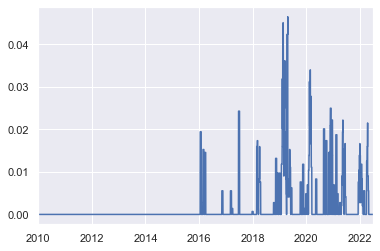

In [5]:
window = 15*24*4

Yi['1'].rolling(window).mean().plot()

### Feature set

In [6]:
train_start, train_end = '2020-01', '2020-12'
eval_start, eval_end = '2021-01', '2021-12'

transform_args = dict(
    drop_empty_cols=True,
    label_encode=data.columns[:11],
    interpolate='linear', fillna='mean'
)

X = custom_preprocessing(data[train_start: eval_end].copy(), **transform_args)

# Validation split
xt = X[train_start: train_end]
xe = X[eval_start: eval_end]

Initial shape: (70176, 241)
Empty columns removed:  (70176, 228)
Label columns encoded: ['year', 'month', 'day', 'hour', 'minute', 'date', 'time', 'dayofyear', 'weekofyear', 'weekday', 'quarter']
Interpolation: linear
Fill missing values: mean


### Target variable

In [13]:
target_id = '1'
periods_ahead = 4
shift = None

Y, groups, y_cnt = select_target(target_id, periods_ahead, shift=shift)

# Target validation split
yt = Y.loc[xt.index]
ye = Y.loc[xe.index]
groups_train = groups.loc[xt.index]
groups_eval = groups.loc[xe.index]

eval_p = (ye.value_counts() / Y.value_counts() * 100).round(2).to_frame('Validation (%)')
display(pd.concat([y_cnt, eval_p], axis=1))

Selected Target: Rua do Catete - id: 1 

Target range: 4


,Target,Transformed Target,Validation (%)
0.0,69784,69672,50.02
1.0,392,504,37.90


---
# 3. Simple split pipeline evaluation

### Base model

In [14]:
seed = 0

sgd = classifiers['SGDClassifier']
model = sgd(loss='log', penalty='l1', alpha=0.0001, l1_ratio=0.15, random_state=0, n_jobs=-1, max_iter=1000, verbose=1, tol=0.01)

### Fit and predict with model pipeline

In [17]:
train_prct = 0.015
rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=seed)

# Pipeline
pipe = Pipeline([('scale', mms()), ('under', rus), ('model', model)])

# Fit pipeline
pipe.fit(xt, yt)

# Predict Probability
yprob = predict_proba(pipe, xe)
# yprob = scale_proba(yprob, 0.5, limit=None)

-- Epoch 1
Norm: 114.87, NNZs: 138, Bias: -13.046835, T: 21179, Avg. loss: 0.323707
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 111.50, NNZs: 117, Bias: -13.550323, T: 42358, Avg. loss: 0.090078
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 110.05, NNZs: 114, Bias: -14.489364, T: 63537, Avg. loss: 0.057884
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 109.27, NNZs: 107, Bias: -15.010368, T: 84716, Avg. loss: 0.042434
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 108.83, NNZs: 103, Bias: -15.068323, T: 105895, Avg. loss: 0.034049
Total training time: 0.21 seconds.
-- Epoch 6
Norm: 108.53, NNZs: 97, Bias: -15.160573, T: 127074, Avg. loss: 0.028989
Total training time: 0.25 seconds.
-- Epoch 7
Norm: 108.30, NNZs: 93, Bias: -15.354259, T: 148253, Avg. loss: 0.025038
Total training time: 0.29 seconds.
-- Epoch 8
Norm: 108.14, NNZs: 94, Bias: -15.428569, T: 169432, Avg. loss: 0.022118
Total training time: 0.33 seconds.
-- Epoch 9
Norm: 108.06, NNZs: 93, Bias: -15.28

### Prediction evaluation

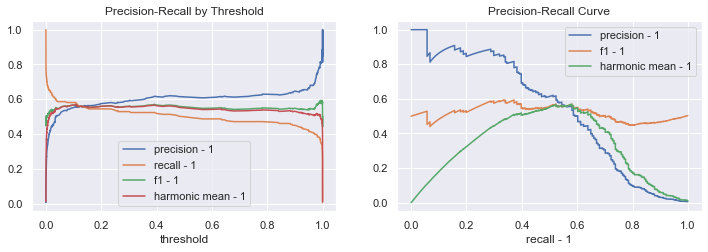

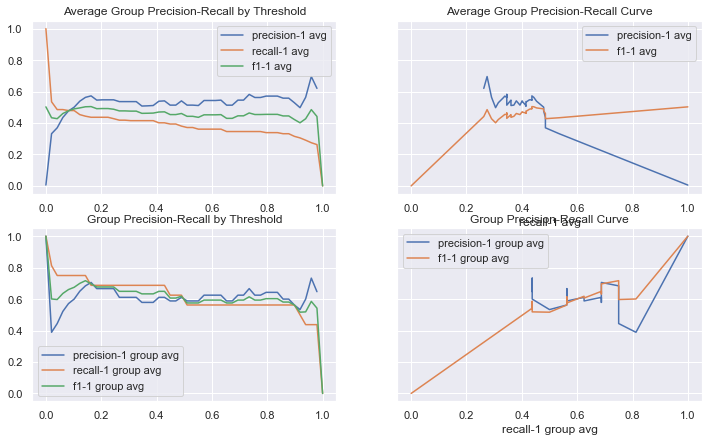

,precision,recall,f1-score,support
0.0,0.997248,0.998278,0.997763,34849.000000
1.0,0.612903,0.497382,0.549133,191.000000
accuracy,0.995548,0.995548,0.995548,0.995548
macro avg,0.805076,0.747830,0.773448,35040.000000
weighted avg,0.995153,0.995548,0.995317,35040.000000


Target groups: 16 



recall-1          0.380145
recall-1 group    0.625000
dtype: float64


Prediction groups: 18 



precision-1          0.540619
precision-1 group    0.611111
dtype: float64

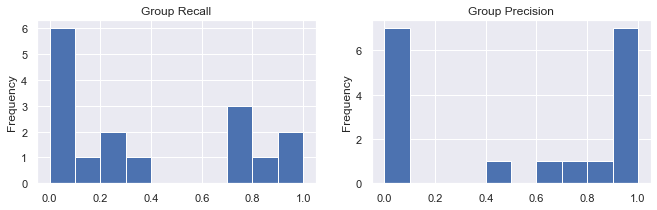

In [18]:
### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(ye, yprob, groups_eval, num=50)

### Selected threshold
sel_thresh = 0.5
yhat = (yprob > sel_thresh).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat)

scr = clf_score(ye, yprob, sel_thresh)
plt.show(); display(scr)
ax = group_metrics.group_precision_recall_stats(ye, yhat, groups_eval, groups_hat)

# Feature Selection

### Feature importance with permutation score

Obs: Testar seleção de features com cross-validação

In [19]:
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

r = permutation_importance(pipe, xe, ye, n_repeats=5,
                           scoring=scoring['f1-1'],
                           random_state=None, n_jobs=-1)

fi = pd.Series(r['importances_mean'], index=xt.columns).sort_values(ascending=False)
selected_columns = fi.index[fi > 0]; print('Selected Features:', f'{len(selected_columns)}/{xt.shape[1]}')

column_trans = ColumnTransformer([('scale', mms(), selected_columns)], remainder='drop')

KeyboardInterrupt: 

### Refit and evaluate pipeline

c:\Users\luisr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear]predict_proba method used.


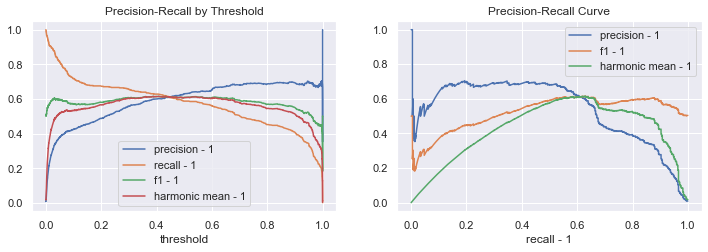

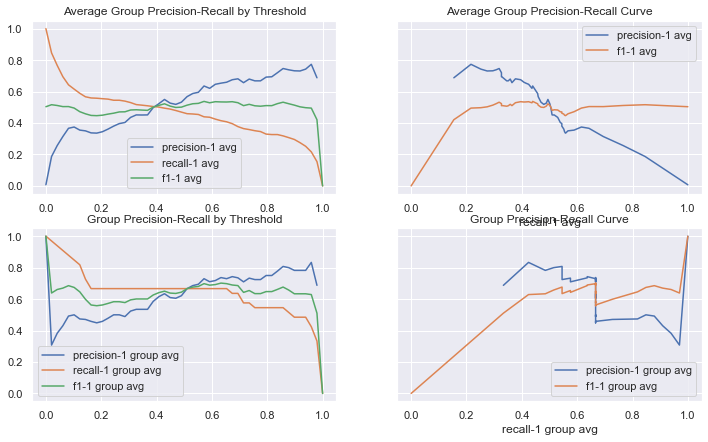

,precision,recall,f1-score,support
0.0,0.996992,0.997500,0.997246,60804.00000
1.0,0.631961,0.587838,0.609102,444.00000
accuracy,0.994530,0.994530,0.994530,0.99453
macro avg,0.814477,0.792669,0.803174,61248.00000
weighted avg,0.994346,0.994530,0.994432,61248.00000


Target groups: 33 



recall-1          0.459120
recall-1 group    0.666667
dtype: float64


Prediction groups: 36 



precision-1          0.567600
precision-1 group    0.666667
dtype: float64

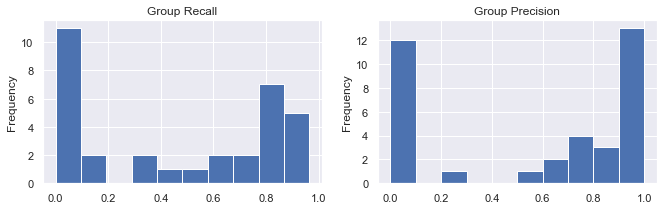

In [233]:
### Fit and predict with model pipeline

# Pipeline
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

# Fit pipeline
pipe.fit(xt, yt)

# Predict Probability
yprob = predict_proba(pipe, xe)
# yprob = scale_proba(yprob, 0.5, limit=None)

### Prediction evaluation

### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(ye, yprob, groups_eval, num=50)

### Selected threshold
sel_thresh = 0.5
yhat = (yprob > sel_thresh).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat)

scr = clf_score(ye, yprob, sel_thresh)
plt.show(); display(scr)
ax = group_metrics.group_precision_recall_stats(ye, yhat, groups_eval, groups_hat)

---
# 4. KFold cross-validation

In [ ]:
scr_cols = np.array(['train_precision-1', 'train_recall-1', 'train_f1-1', 'test_precision-1', 'test_recall-1', 'test_f1-1'], dtype='object')
stats_cols = ['mean', 'std', 'min', '50%', 'max']

### Minority group kfold split - cross validation

In [235]:
display(pipe)

splitter = MinorityGroupSplitUndersample(
    n_splits=10,
    # train_size=0.80, test_size=0.19,
    train_prct=None, test_prct='natural',
    random_state=seed,
)

cv_group = splitter.split(xt, yt, groups_train, strategy='GroupKFold')

# evaluate splits
scr_group =  pd.DataFrame(cross_validate(
    pipe, xt, yt, groups=groups_train,
    scoring=scoring, cv=cv_group,
    n_jobs=-1, verbose=5,
    return_train_score=True,
))

display(scr_group[scr_cols].describe().loc[['mean', 'std']])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished


,train_precision-1,train_recall-1,train_f1-1,test_precision-1,test_recall-1,test_f1-1
mean,0.684475,0.792643,0.734568,0.583425,0.750740,0.655373
std,0.008191,0.008377,0.006701,0.036095,0.107042,0.062104


---
# 5. Time series split cross-validation

### Time series based split pipeline

In [245]:
n_splits = 10

splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
cv_time = list(splitter.split(X, Y))

# Fill test folders
for i in range(n_splits):
    cv_time[i] = (cv_time[i][0], np.arange(cv_time[i][1].min(), len(X)))

display(pipe)

Pipeline(steps=[('scale',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  Index(['acumulado_chuva_4_h - 31', 'acumulado_chuva_96_h - 30',
       'acumulado_chuva_4_h - 5', 'acumulado_chuva_1_h - 31',
       'acumulado_chuva_24_h - 15', 'acumulado_chuva_1_h - 15',
       'rajada_vento_max - A652', 'acumulado_chuva_4_h - 19',
       'acumulado_chuva_24_h - 22', 'acumulado_chuva_24_h - 32',
       'acumulado...
       'acumulado_chuva_15_min - 27', 'rajada_vento_max - A636',
       'radiacao_global - A602', 'acumulado_chuva_24_h - 31', 'hour',
       'pressao_minima - A636', 'pressao - A602', 'minute'],
      dtype='object'))])),
                ('under',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.025)),
                ('model',
                 LogisticRegression(n_jobs=-1, penalty='l1', random_state=0,
                                    solver='liblinear', tol=0.001,
             

### Cross-validation score

In [246]:
# evaluate splits
scr_time = pd.DataFrame(cross_validate(
    pipe, X, Y, # groups=groups_train,
    scoring=group_metrics.group_scorer, cv=cv_time,
    return_train_score=True,
    error_score=np.nan,
    n_jobs=-1, verbose=5,
    pre_dispatch='2*n_jobs',
))

# Reset score index by test start
test_start = []
for train, test in cv_time:
    test_start.append(X.iloc[test].index.min())
scr_time.index = test_start

# Test class proportion
mean_1 = pd.DataFrame(
    mms().fit_transform([[Y[cv[0]].mean(), Y[cv[1]].mean()] for cv in cv_time]),
    columns=['train_support-1 normalized', 'test_support-1 normalized'], index=scr_time.index
)
not_null = ~mean_1.iloc[:, 0].isin([0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.1s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.0s finished


### Temporal performance

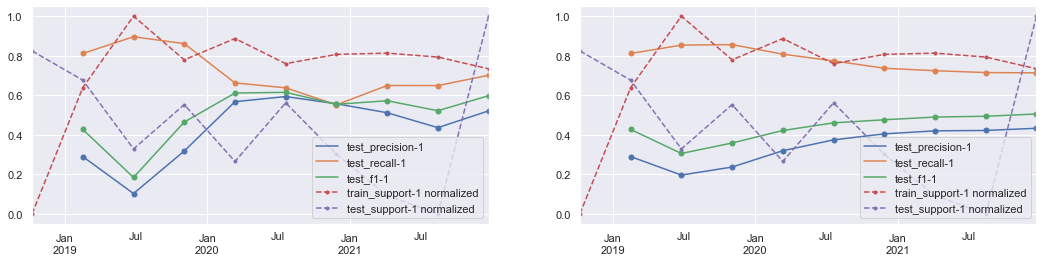

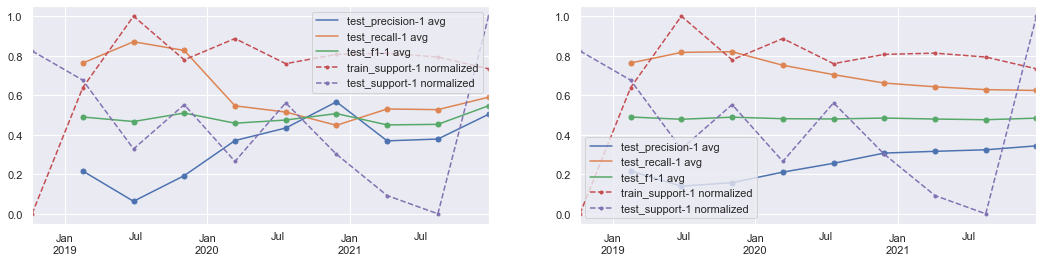

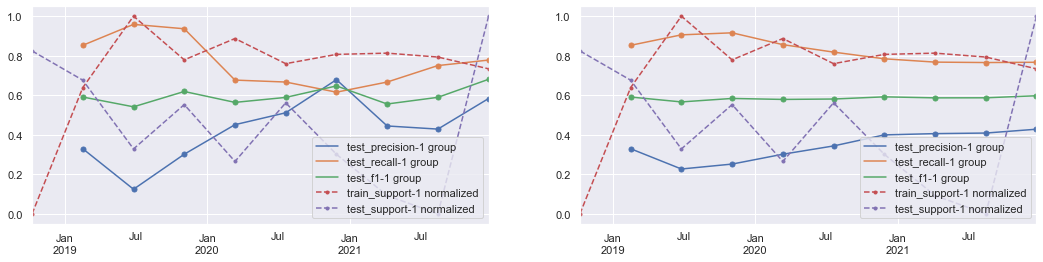

,train_precision-1,train_recall-1,train_f1-1,test_precision-1,test_recall-1,test_f1-1
mean,0.685809,0.786185,0.732025,0.432786,0.713086,0.505077
50%,0.678797,0.772487,0.732748,0.511364,0.662309,0.553945
std,0.050422,0.045455,0.044015,0.164279,0.116051,0.136843


,train_precision-1 avg,train_recall-1 avg,train_f1-1 avg,test_precision-1 avg,test_recall-1 avg,test_f1-1 avg
mean,0.502372,0.722501,0.612436,0.343882,0.624016,0.483949
50%,0.473321,0.701354,0.603033,0.370627,0.546225,0.474414
std,0.076086,0.060754,0.060041,0.159420,0.153885,0.032347


,train_precision-1 group,train_recall-1 group,train_f1-1 group,test_precision-1 group,test_recall-1 group,test_f1-1 group
mean,0.584900,0.885302,0.735101,0.427995,0.766659,0.597327
50%,0.558824,0.898305,0.725543,0.444444,0.750000,0.589286
std,0.097600,0.033819,0.054210,0.163034,0.124625,0.044784


In [247]:
for col_type in ['', ' avg', ' group']:
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    
    scr_time[scr_cols[3:6] + col_type].plot(marker='o', ms=5, ax=ax[0])
    mean_1.plot(linestyle='--', marker='.', ax=ax[0])

    scr_time[scr_cols[3:6] + col_type].rolling(100, min_periods=1).mean().plot(marker='o', ms=5, ax=ax[1])
    mean_1.plot(linestyle='--', marker='.', ax=ax[1])

    plt.show()

for col_type in ['', ' avg', ' group']:
    ### Average temporal performance
    display(scr_time.describe().loc[['mean', '50%', 'std'], scr_cols + col_type])

---
# Number of splits optimization

In [249]:
min_splits, max_splits, jump = 2, 10, 1
fill_test = True

scrs = []
n_splits_i = range(2, max_splits + 1, jump)
for n_splits in n_splits_i:
    co(wait=True); print(f'{n_splits}/{max_splits} splits evaluated')

    splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
    cv_time = list(splitter.split(X, Y))

    if fill_test: # Fill test folders
        for i in range(n_splits):
            cv_time[i] = (cv_time[i][0], np.arange(cv_time[i][1][0], len(X)))

    scr_time = pd.DataFrame(cross_validate(
        pipe, X, Y, # groups=groups_train,
        scoring=group_metrics.group_scorer, cv=cv_time,
        return_train_score=True,
        error_score=np.nan,
        n_jobs=-1, verbose=5,
        pre_dispatch='2*n_jobs',
    ))

    scr_time['n_splits'] = n_splits
    scrs.append(scr_time)

scrs = pd.concat(scrs)

10/10 splits evaluated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.3s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.2s finished


### Average scores

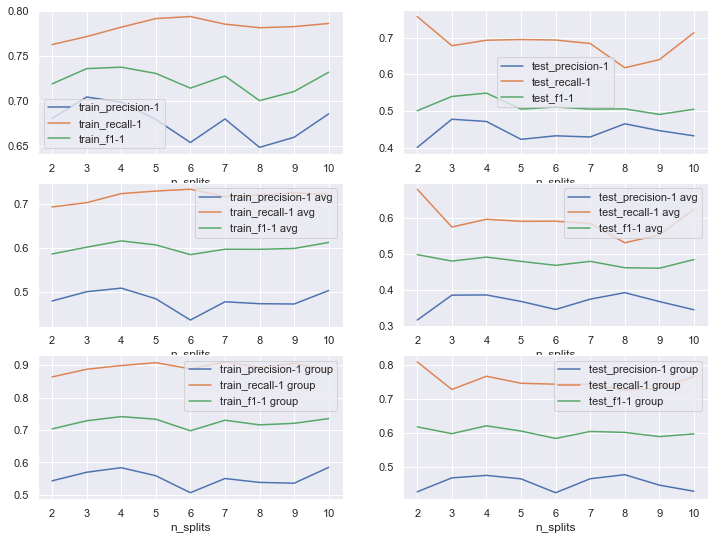

In [252]:
fig, ax = plt.subplots(3, 2, figsize=(12, 9))
for i, col_type in enumerate(['', ' avg', ' group']):
    for j, cols_index in enumerate([[0,1,2], [3,4,5]]):
        scrs.groupby('n_splits').mean()[scr_cols[cols_index] + col_type].plot(ax=ax[i][j])#, title='Time Series N° of Splits Optimization')

### Scores deviation

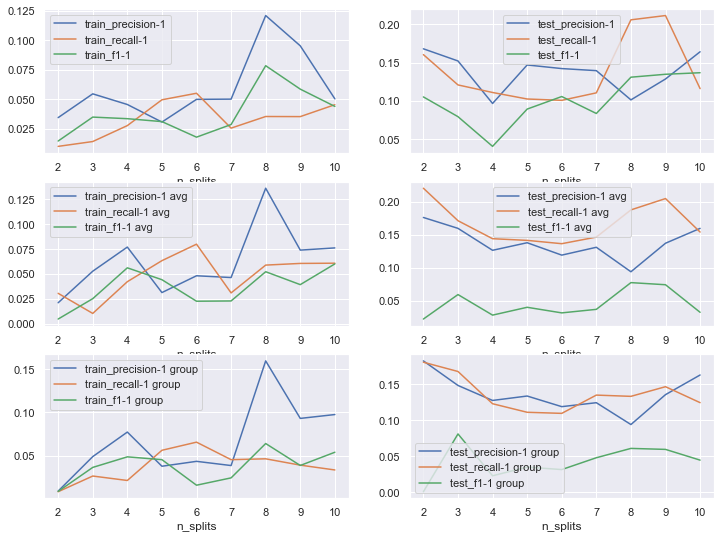

In [253]:
fig, ax = plt.subplots(3, 2, figsize=(12, 9))
for i, col_type in enumerate(['', ' avg', ' group']):
    for j, cols_index in enumerate([[0,1,2], [3,4,5]]):
        scrs.groupby('n_splits').std()[scr_cols[cols_index] + col_type].plot(ax=ax[i][j])#, title='Time Series N° of Splits Optimization')

---
# Concatenated splits' probabilities

### Time series based split

In [101]:
scale = True
def cross_val_predict_proba(estimator, X, Y, cv, calibrate=None):
    yprob_cv = []
    for i, (train, test) in enumerate(cv):
        try:
            estimator.fit(X.iloc[train], Y.iloc[train])
            yprob = predict_proba(estimator, X.iloc[test])
            # Optional scale probabilities
            if calibrate is not None:
                yprob = scale_proba(yprob, threshold=calibrate, limit=None)
            yprob_cv.append(yprob.values)
        except Exception as e:
            yprob_cv.append(np.array([np.nan] * len(test)))
            print('cross_val_predict_proba error:', e)
        co(True); print(f'cv: {i+1}/{len(cv)}')
    return yprob_cv

### Concatenated splits' probabilities

### Time series based split pipeline

In [275]:
from sklearn.model_selection import TimeSeriesSplit

n_splits = 7; display(pipe)

splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
cv_time = list(splitter.split(X, Y))

# Fill test folders
# for i in range(n_splits):
#     cv_time[i] = (cv_time[i][0], np.arange(cv_time[i][1][0], len(X)))

test_index = X.index[cv_time[0][1][0] :]

Ye = Y.loc[test_index]
groups_e = groups.loc[test_index]

yprob_cv = cross_val_predict_proba(pipe, X, Y, cv_time, calibrate=None)

yprob = pd.Series(np.concatenate(yprob_cv), index=test_index)#.dropna()

yhat = (yprob > 0.5).astype('float')
groups_hat = groupConsecutiveFlags(ts=yhat)

cv: 7/7


### Probability time serie plot

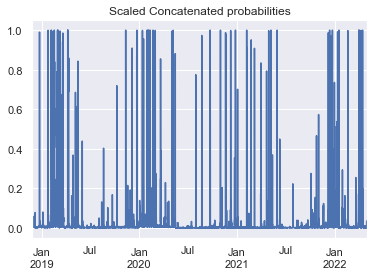

In [276]:
ax = yprob.plot(title='Scaled Concatenated probabilities')

### Whole period evaluation

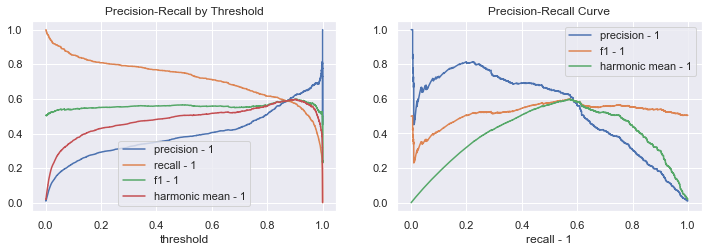

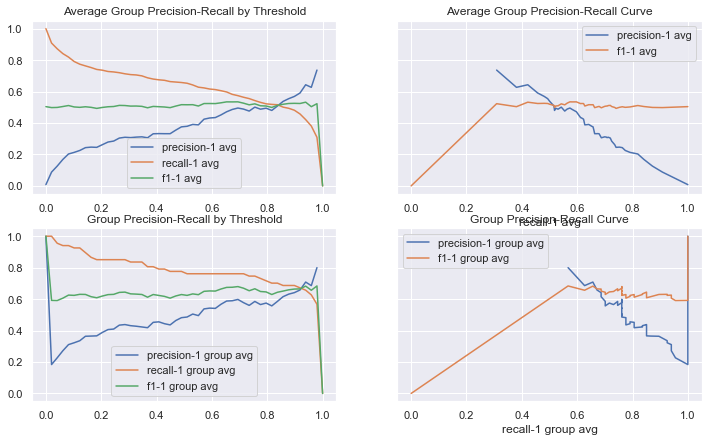

,precision,recall,f1-score,support
0.0,0.998004,0.990291,0.994133,119172.000000
1.0,0.380952,0.751055,0.505502,948.000000
accuracy,0.988403,0.988403,0.988403,0.988403
macro avg,0.689478,0.870673,0.749818,120120.000000
weighted avg,0.993134,0.988403,0.990277,120120.000000


Target groups: 67 



recall-1          0.656903
recall-1 group    0.776119
dtype: float64


Prediction groups: 108 



precision-1          0.383336
precision-1 group    0.490741
dtype: float64

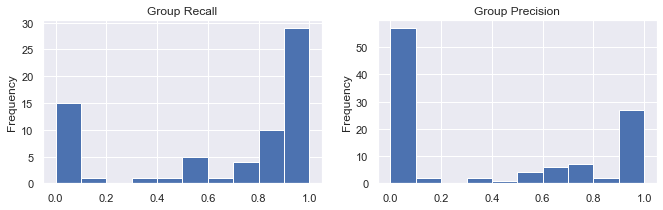

In [277]:
### Evaluate prediction
ax = precision_recall_plot(Ye, yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(Ye, yprob, groups_e, num=50)

### Selected threshold score
scr = clf_score(Ye, yprob, 0.5)
plt.show(); display(scr)
ax = group_metrics.group_precision_recall_stats(Ye, yhat, groups_e, groups_hat)

# Probability windows

#### Conclusions

##### Trends:
1. Not identified events
1. high probability in the middle of event
1. After start of event
1. Before start of event
1. After end of event

In [47]:
def groups_windows(groups, spread=6, freq=pd.Timedelta(1, 'h')):
    windows = []; wide = spread * freq
    for group in groups.unique():
        group_index = groups.index[groups==group]
        grp_min, grp_max = group_index.min(), group_index.max()
        windows.append((grp_min - wide, grp_max + wide))
    return windows

def window_prob(ye, yprob, time_lim, ax=None):
    yprob = pd.Series(mms().fit_transform(yprob.to_frame()).reshape(-1), index=yprob.index) # scale probability to 0-1 range
    msk = ye.index.to_series().between(*time_lim) # time window limits
    if ax is None: ax = plt.axes()
    yprob[msk].plot(ax=ax)
    ax = ye[msk].plot(ax=ax)
    return ax

def multi_window_prob(ye, yprob, windows, n_cols, title='Probability {} - {}', path=None):
    n_plots = len(windows)
    n_rows = int(n_plots / n_cols if n_plots % n_cols == 0 else n_plots // n_cols + 1)
    figsize = (6 * n_cols, 4 * n_rows)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, tight_layout=True, sharey=True)
    axs = list(axs.reshape(-1))
    i=0
    for ax, time_lim in zip(axs, windows):
        i+=1; co(wait=True); print(f'{i}/{len(windows)}')
        msk = ye.index.to_series().between(time_lim[0], time_lim[1]) # time window limits
        yprob[msk].plot(ax=ax)
        ye[msk].plot(ax=ax)
        time_min, time_max = (time_lim[j].strftime('%d-%h-%y %H:%m') for j in (0, 1))
        ax.set(title=title.format(time_min, time_max))
    if path is not None: plt.savefig(path)
    return fig, axs

### True and false positives

115/115


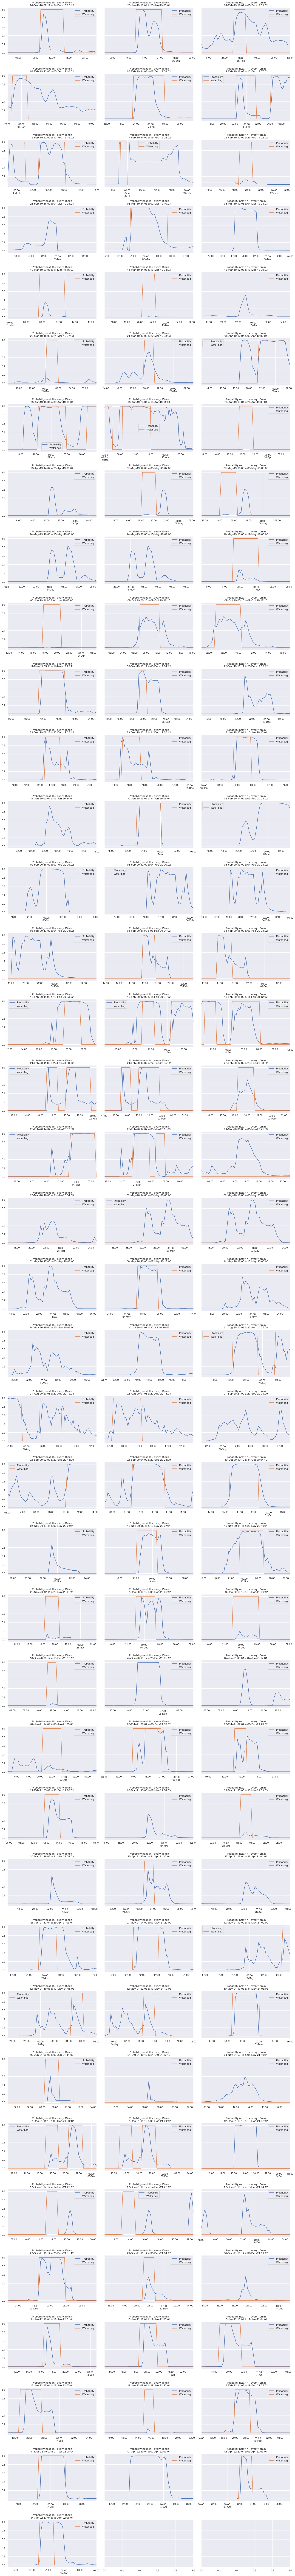

In [53]:
Y_positive = ((Ye + yhat) > 0.0).astype('float')

groups_positive = groupConsecutiveFlags(Y_positive)

windows =  groups_windows(groups_positive[groups_positive!=-1], spread=6, freq=pd.Timedelta(1, 'h'))

n_cols = 3
title = 'Probability next 1h - every 15min\n{} à {}'
path = 'Modelagem de Bolsões/Scores/Probabilidade Bolsões-Previsões.pdf'

fig, axs = multi_window_prob(
    Ye.to_frame('Water bag'),
    yprob.to_frame('Probability'),
    windows, n_cols, title, path,
)